In [29]:
import os
import rasterio
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import tensorflow as tf

In [7]:
def load_tiff_data(image_dir, label_dir):
    """
    Loads images and labels from .tiff files.
    
    Parameters:
        image_dir (str): Directory containing the image files.
        label_dir (str): Directory containing the label files.

    Returns:
        images (np.ndarray): Array of images.
        labels (np.ndarray): Array of labels.
    """
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tiff')])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.tiff')])

    images, labels = [], []
    for img_file, lbl_file in zip(image_files, label_files):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=rasterio.errors.NotGeoreferencedWarning)
            with rasterio.open(os.path.join(image_dir, img_file)) as img:
                images.append(img.read().transpose(1, 2, 0))  # Rearrange to HxWxC
            with rasterio.open(os.path.join(label_dir, lbl_file)) as lbl:
                labels.append(lbl.read(1))  # Assume single-band labels

    return np.array(images), np.array(labels)

In [8]:
# Directories for filtered data
image_dir_2016 = '../data/filtered/images_2016'
label_dir_2016 = '../data/filtered/targets_2016'
image_dir_2021 = '../data/filtered/images_2021'
label_dir_2021 = '../data/filtered/targets_2021'

In [75]:
# Load datasets
images_2016, labels_2016 = load_tiff_data(image_dir_2016, label_dir_2016)
images_2021, labels_2021 = load_tiff_data(image_dir_2021, label_dir_2021)
# Verify shapes
print(f"2016: Images {images_2016.shape}, Labels {labels_2016.shape}")
print(f"2021: Images {images_2021.shape}, Labels {labels_2021.shape}")

2016: Images (1565, 85, 85, 3), Labels (1565, 85, 85)
2021: Images (1565, 85, 85, 3), Labels (1565, 85, 85)


In [11]:
# File: model_training.py

# Assuming images_2016 and labels_2016 are loaded
# Assuming images_2021 and labels_2021 are loaded

# Normalizing images to [0, 1]
images_2016 = images_2016 / 255.0
images_2021 = images_2021 / 255.0

# Split 2016 data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images_2016, labels_2016, test_size=0.2, random_state=42
)

In [18]:
def build_unet(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = tf.keras.layers.concatenate([u1, c2])
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    c1_cropped = tf.keras.layers.Cropping2D(((1, 0), (1, 0)))(c1)
    u2 = tf.keras.layers.concatenate([u2, c1_cropped])

    c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    # Output layer with padding to match label dimensions
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    outputs = tf.keras.layers.ZeroPadding2D(((1, 0), (1, 0)))(outputs)  # Adjust dimensions

    model = tf.keras.Model(inputs, outputs)
    return model

In [19]:
# Build and compile the model
input_shape = X_train.shape[1:]  # (85, 85, 3)
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # Adjust based on your requirements
    batch_size=32
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.7653 - loss: 0.5970 - val_accuracy: 0.8554 - val_loss: 0.4601
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8411 - loss: 0.4786 - val_accuracy: 0.8554 - val_loss: 0.4165
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8382 - loss: 0.4381 - val_accuracy: 0.8703 - val_loss: 0.3546
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8665 - loss: 0.3801 - val_accuracy: 0.8809 - val_loss: 0.3439
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8776 - loss: 0.3663 - val_accuracy: 0.8974 - val_loss: 0.3441
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8531 - loss: 0.5084 - val_accuracy: 0.8852 - val_loss: 0.4340
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8714 - loss: 0.3773 - val_accuracy: 0.9034 - val_loss: 0.2906
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9136 - loss: 0.2837 - val_accuracy: 0.9186 - val_loss:

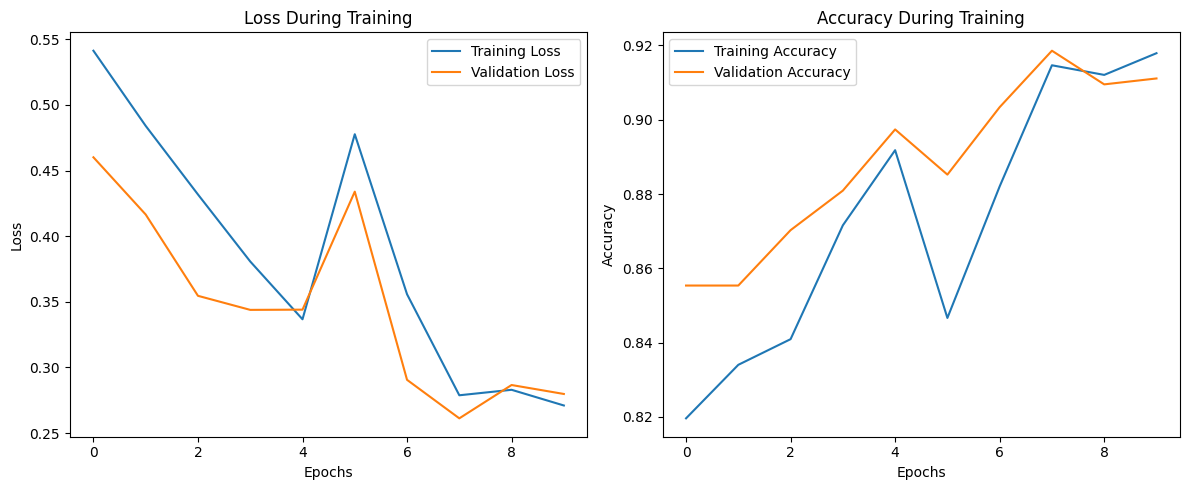

In [21]:
def plot_training_history(history):
    """
    Plots training and validation loss and accuracy.

    Parameters:
        history: History object returned by model.fit().
    """
    # Loss
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)

In [26]:
# Predict 2021 data
predictions = model.predict(images_2021)
threshold = 0.5
predictions_binary = (predictions > threshold).astype(int)

# Flatten para calcular métricas em todos os pixels
y_true = labels_2021.flatten()
y_pred = predictions_binary.flatten()


# IoU (Jaccard Score)
iou = jaccard_score(y_true, y_pred)
print(f"IoU (Intersection over Union): {iou:.4f}")

# F1-Score
f1 = f1_score(y_true, y_pred)
print(f"F1-Score: {f1:.4f}")

# Precisão e Recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 393ms/step - accuracy: 0.7967 - loss: 0.7853
Test Loss: 0.7029901146888733, Test Accuracy: 0.818085253238678


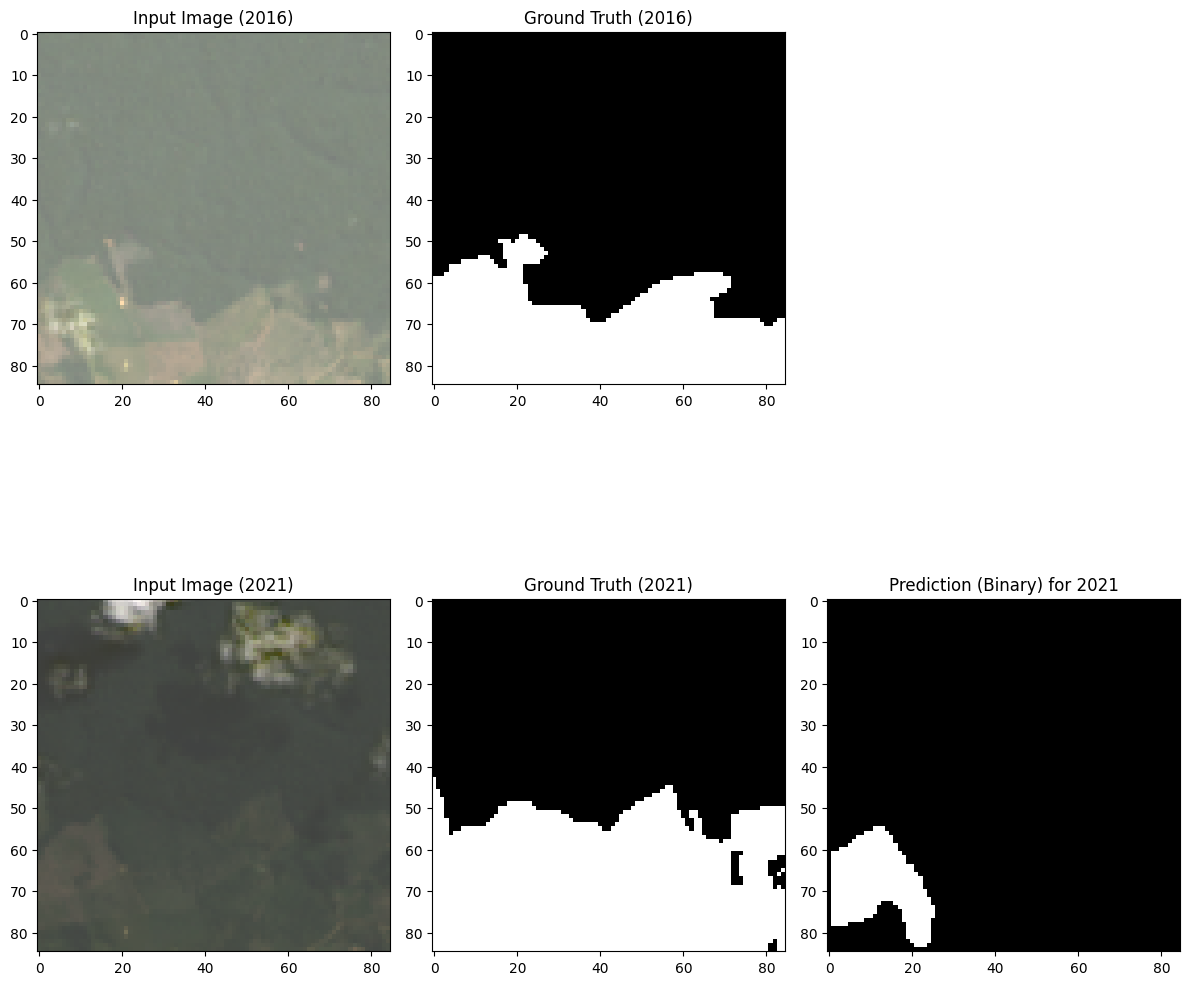

In [70]:
index = 500
# Escolha uma imagem para visualizar
plt.figure(figsize=(12, 12))

# Linha 1: Dados de 2016
plt.subplot(2, 3, 1)
plt.title("Input Image (2016)")
plt.imshow(images_2016[index])  # Substitua por sua variável para as imagens de 2016

plt.subplot(2, 3, 2)
plt.title("Ground Truth (2016)")
plt.imshow(labels_2016[index], cmap='gray')  # Label correspondente a 2016

# Linha 2: Dados de 2021
plt.subplot(2, 3, 4)
plt.title("Input Image (2021)")
plt.imshow(images_2021[index])  # Substitua por sua variável para as imagens de 2021

plt.subplot(2, 3, 5)
plt.title("Ground Truth (2021)")
plt.imshow(labels_2021[index], cmap='gray')  # Label correspondente a 2021

plt.subplot(2, 3, 6)
plt.title("Prediction (Binary) for 2021")
plt.imshow(predictions_binary[index].squeeze(), cmap='gray')  # Previsão binária para 2021

plt.tight_layout()
plt.show()

In [73]:
def find_image_by_coordinates(lat, lon, year, base_dir, prefix):
    """
    Finds the file that corresponds to the given latitude and longitude for the specified year and prefix.
    
    Parameters:
        lat (float): Latitude of the location.
        lon (float): Longitude of the location.
        year (int): Year of the file (2016 or 2021).
        base_dir (str): Base directory containing the folders.
        prefix (str): Prefix for the file (e.g., "Deforestation_" or "Landsat8_SR_RGB_").
    
    Returns:
        str: Path to the file.
    """
    # Determine the folder based on year and type (images or targets)
    if prefix == "Deforestation_":
        folder = f"targets_{year}"
    elif prefix == "Landsat8_SR_RGB_":
        folder = f"images_{year}"
    else:
        raise ValueError(f"Unknown prefix: {prefix}")

    # Match file based on prefix, coordinates, and year
    search_pattern = f"{prefix}{lon:.2f}_{lat:.2f}_{year}_"  # Match coordinate part

    # Search for the matching file
    folder_path = os.path.join(base_dir, folder)
    for file_name in os.listdir(folder_path):
        if file_name.startswith(search_pattern):
            return os.path.join(folder_path, file_name)
    
    raise FileNotFoundError(f"File not found for coordinates: {lat}, {lon} in {year} with prefix {prefix}")

In [74]:
# # Test Find Images Function
# def test_find_image_by_coordinates():
#     """
#     Test function to validate find_image_by_coordinates.
#     """
#     # Configurações do diretório base
#     base_dir = "data/filtered"  # Ajuste para o caminho do seu projeto
#     os.makedirs(f"{base_dir}/images_2021", exist_ok=True)
#     os.makedirs(f"{base_dir}/targets_2016", exist_ok=True)

#     # Criação de arquivos fictícios para teste
#     test_files = [
#         f"Deforestation_-55.20_-4.39_2016_08_01.tiff",
#         f"Deforestation_-55.20_-4.39_2021_05_01.tiff",
#         f"Landsat8_SR_RGB_-55.20_-4.39_2021_05_26.tiff",
#         f"Landsat8_SR_RGB_-55.20_-4.39_2016_08_16.tiff",
#     ]
    
#     # Escrevendo arquivos fictícios nas pastas corretas
#     for file_name in test_files:
#         if "2021" in file_name:
#             folder = "images_2021" if "Landsat8" in file_name else "targets_2021"
#         elif "2016" in file_name:
#             folder = "images_2016" if "Landsat8" in file_name else "targets_2016"
#         file_path = os.path.join(base_dir, folder, file_name)
#         os.makedirs(os.path.dirname(file_path), exist_ok=True)
#         with open(file_path, "w") as f:
#             f.write("")  # Arquivo vazio para teste

#     # Coordenadas e prefixos de teste
#     test_cases = [
#         {"lat": -4.39, "lon": -55.20, "year": 2016, "prefix": "Deforestation_", "expected": "targets_2016"},
#         {"lat": -4.39, "lon": -55.20, "year": 2021, "prefix": "Deforestation_", "expected": "targets_2021"},
#         {"lat": -4.39, "lon": -55.20, "year": 2021, "prefix": "Landsat8_SR_RGB_", "expected": "images_2021"},
#         {"lat": -4.39, "lon": -55.20, "year": 2016, "prefix": "Landsat8_SR_RGB_", "expected": "images_2016"},
#     ]

#     # Executando os testes
#     for test in test_cases:
#         try:
#             result = find_image_by_coordinates(
#                 test["lat"], test["lon"], test["year"], base_dir, test["prefix"]
#             )
#             expected_folder = os.path.join(base_dir, test["expected"])
#             assert result.startswith(expected_folder), f"Failed test case: {test}"
#             print(f"Passed: {test}")
#         except Exception as e:
#             print(f"Failed: {test} -> {e}")

# # Rodar os testes
# test_find_image_by_coordinates()

Failed: {'lat': -3.93, 'lon': -55.2, 'year': 2016, 'prefix': 'Deforestation_', 'expected': 'targets_2016'} -> File not found for coordinates: -3.93, -55.2 in 2016 with prefix Deforestation_
Failed: {'lat': -3.93, 'lon': -55.2, 'year': 2021, 'prefix': 'Deforestation_', 'expected': 'targets_2021'} -> File not found for coordinates: -3.93, -55.2 in 2021 with prefix Deforestation_
Failed: {'lat': -3.93, 'lon': -55.2, 'year': 2021, 'prefix': 'Landsat8_SR_RGB_', 'expected': 'images_2021'} -> File not found for coordinates: -3.93, -55.2 in 2021 with prefix Landsat8_SR_RGB_
Failed: {'lat': -3.93, 'lon': -55.2, 'year': 2016, 'prefix': 'Landsat8_SR_RGB_', 'expected': 'images_2016'} -> File not found for coordinates: -3.93, -55.2 in 2016 with prefix Landsat8_SR_RGB_


In [44]:
def calculate_deforestation(lat, lon, base_dir, model):
    """
    Calculate deforestation percentage for a given latitude and longitude.

    Parameters:
        lat (float): Latitude of the location.
        lon (float): Longitude of the location.
        base_dir (str): Base directory containing image and target folders.
        model (keras.Model): Pre-trained segmentation model.

    Returns:
        float: Deforestation Percentage.
    """
    # Find corresponding files with appropriate prefixes
    image_2021_path = find_image_by_coordinates(lat, lon, 2021, base_dir, "Landsat8_SR_RGB_")
    target_2016_path = find_image_by_coordinates(lat, lon, 2016, base_dir, "Deforestation_")

    # Load images
    with rasterio.open(image_2021_path) as img_2021:
        img_2021_array = img_2021.read().transpose(1, 2, 0) / 255.0  # Normalize

    with rasterio.open(target_2016_path) as target_2016:
        target_2016_array = target_2016.read(1)  # Single band

    # Predict
    prediction = model.predict(np.expand_dims(img_2021_array, axis=0))
    prediction_binary = (prediction.squeeze() > 0.5).astype(int)

    # Calculate deforestation percentage
    area_2016 = np.sum(target_2016_array == 1)
    area_2021 = np.sum(prediction_binary == 1)
    deforestation_percentage = ((area_2021 - area_2016) / area_2016) * 100

    return deforestation_percentage

In [50]:
# def test_calculate_deforestation_with_real_model():
#     """
#     Test the calculate_deforestation function using the real trained model.
#     """
#     # Diretório base onde estão as imagens e os targets
#     base_dir = "../data/filtered"  # Ajuste conforme necessário
    
#     # Coordenadas de teste
#     lat, lon = -4.39, -55.20  # Substitua pelas coordenadas desejadas
    
#     # Modelo real já treinado
#     global model  # Certifique-se de que o modelo foi carregado no script
#     if model is None:
#         print("Modelo não carregado! Verifique se o modelo foi inicializado.")
#         return
    
#     try:
#         # Executar o cálculo do desmatamento
#         deforestation_percentage = calculate_deforestation(lat, lon, base_dir, model)
        
#         # Exibir o resultado
#         print(f"Deforestation percentage for {lat}, {lon}: {deforestation_percentage:.2f}%")
    
#     except FileNotFoundError as e:
#         print(f"Erro: Arquivo não encontrado - {e}")
#     except Exception as e:
#         print(f"Erro durante o teste: {e}")

# # Rodar o teste
# test_calculate_deforestation_with_real_model()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Deforestation percentage for -4.39, -55.2: -63.73%


In [77]:
model.save("trained_model.keras")